In [127]:
from UNetPyTorch import *

import xarray as xr
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from datetime import datetime

import cartopy
import cartopy.crs as ccrs

from torch.utils.data import DataLoader, Dataset

from IPython.display import HTML

ds = xr.open_dataset('1_WindSpeedForecasting/data_850/2020to2022_coarsened.nc')
ds.load()

<xarray.Dataset> Size: 539MB
Dimensions:    (time: 26304, latitude: 16, longitude: 32)
Coordinates:
  * time       (time) datetime64[ns] 210kB 2020-01-01 ... 2022-12-31T23:00:00
  * longitude  (longitude) float32 128B 16.31 16.81 17.31 ... 30.81 31.31 31.81
  * latitude   (latitude) float32 64B -27.14 -27.64 -28.14 ... -34.14 -34.64
Data variables:
    q          (time, latitude, longitude) float64 108MB 0.001576 ... 0.003407
    t          (time, latitude, longitude) float64 108MB 294.3 294.5 ... 280.7
    u          (time, latitude, longitude) float64 108MB -1.134 ... -0.4352
    v          (time, latitude, longitude) float64 108MB 3.234 3.353 ... -2.969
    w          (time, latitude, longitude) float64 108MB 0.05626 ... 0.1397
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-28 10:29:17 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

### Model

In [128]:
class build_res_unet(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        ''' Encoder 1 '''
        self.c11 = nn.Conv2d(in_c, 32, kernel_size=3, padding=1)
        self.br1 = batchnorm_relu(32)
        self.c12 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.c13 = nn.Conv2d(in_c, 32, kernel_size=1, padding=0) # Shortcut feature

        """ Encoder 2 and 3 """
        self.r2 = residual_block(32, 64, stride=2)
        self.r3 = residual_block(64, 128, stride=2)

        """ Bridge """
        self.r4 = residual_block(128, 256, stride=2)

        """ Decoder """
        self.d1 = decoder_block(256, 128)
        self.d2 = decoder_block(128, 64)
        self.d3 = decoder_block(64, 32)

        """ Output """
        self.output = nn.Conv2d(32, out_c, kernel_size=1, padding=0)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        """ Encoder 1 """
        x = self.c11(inputs)
        x = self.br1(x)
        x = self.c12(x)
        s = self.c13(inputs)
        skip1 = x + s

        """ Encoder 2 and 3 """
        skip2 = self.r2(skip1)
        skip3 = self.r3(skip2)

        """ Bridge """
        b = self.r4(skip3)

        """ Decoder """
        d1 = self.d1(b, skip3)
        d2 = self.d2(d1, skip2)
        d3 = self.d3(d2, skip1)

        """ output """
        output = self.output(d3)
        # output = self.sigmoid(output)

        return output

class build_res_unet_time_(nn.Module):
    def __init__(self, in_c, out_c, start_size = 64):
        super().__init__()

        ''' Encoder 1 '''
        self.c11 = nn.Conv2d(in_c + 2, start_size, kernel_size=3, padding=1)  # in_c + 2 to account for time inputs
        self.br1 = batchnorm_relu(start_size)
        self.c12 = nn.Conv2d(start_size, start_size, kernel_size=3, padding=1)
        self.c13 = nn.Conv2d(in_c + 2, start_size, kernel_size=1, padding=0)  # Shortcut feature

        """ Encoder 2 and 3 """
        self.r2 = residual_block(start_size, start_size * 2, stride=2)
        self.r3 = residual_block(start_size * 2, start_size * 4, stride=2)

        """ Bridge """
        self.r4 = residual_block(start_size * 4, start_size * 8, stride=2)

        """ Decoder """
        self.d1 = decoder_block(start_size * 8, start_size * 4)
        self.d2 = decoder_block(start_size * 4, start_size * 2)
        self.d3 = decoder_block(start_size * 2, start_size)

        """ Output """
        self.output = nn.Conv2d(start_size, out_c, kernel_size=1, padding=0)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, weather_data, time_input):
        # weather_data shape: (batch_size, window_size, lat, lon)
        # time_input shape: (batch_size, window_size, 2) where 2 corresponds to (hour of day, month of year)

        batch_size, window_size, lat, lon = weather_data.shape

        # Reshape weather_data to (batch_size, window_size, 1, lat, lon)
        weather_data = weather_data.view(batch_size, window_size, lat, lon)

        # Expand time_input to match the spatial dimensions of the weather data
        time_input = time_input.view(batch_size, 2)  # (batch_size, window_size, 2)

        # Expand to match spatial dimensions (lat, lon) and channel 2 for (hour, month)
        time_input_expanded = time_input.unsqueeze(-1).unsqueeze(-1)  # Add spatial dimensions
        time_input_expanded = time_input_expanded.expand(-1, -1, lat, lon)  # Now shape is (batch_size, 2, lat, lon)

        # Concatenate along the channel axis
        combined_input = torch.cat([weather_data, time_input_expanded], dim=1)  # New shape: (batch_size, in_c + 2, lat, lon)

        """ Encoder 1 """
        x = self.c11(combined_input)
        x = self.br1(x)
        x = self.c12(x)
        s = self.c13(combined_input)
        skip1 = x + s

        """ Encoder 2 and 3 """
        skip2 = self.r2(skip1)
        skip3 = self.r3(skip2)

        """ Bridge """
        b = self.r4(skip3)

        """ Decoder """
        d1 = self.d1(b, skip3)
        d2 = self.d2(d1, skip2)
        d3 = self.d3(d2, skip1)

        """ Output """
        output = self.output(d3)
        # output = self.sigmoid(output)

        return output

class WeatherData(Dataset):
    def __init__(self, dataset: xr.Dataset, window_size: int = 24, steps: int = 3, auto = False, use_forcings = False, intervals = 1):
        self.dataset = dataset
        self.window_size = window_size
        self.steps = steps
        self.calculate_wind_speed()
        self.dataset = self.dataset.sortby('latitude')

        self.min_value = self.dataset.wspd.min().item()
        self.max_value = self.dataset.wspd.max().item()

        self.mean_value = self.dataset.wspd.mean().item()
        self.std_value = self.dataset.wspd.std().item()

        self.use_forcings = use_forcings

        if auto:
            if intervals > 1:
                self.time_intervals(intervals)
            self.window_dataset()
            self.split_data()    
            self.normalize_data()    

    def __len__(self):
        return len(self.X_train)
    
    def __getitem__(self, idx):
        return self.X_train_t[idx], self.F_train_t[idx], self.y_train_t[idx]
    
    def time_intervals(self, intervals = 3):
        self.dataset = self.dataset.sel(time=slice(None, None, intervals))

    def subset_data(self, coarsen = 1):
        if coarsen > 1:
            lat_slice = slice(1, 33, coarsen)
            lon_slice = slice(3, 67, coarsen)
        else:
            lat_slice = slice(1, 33)  
            lon_slice = slice(3, 67)

        self.dataset = self.dataset.isel(latitude=lat_slice, longitude=lon_slice)

    def calculate_wind_speed(self):
        self.dataset['wspd'] = np.sqrt(self.dataset.u**2 + self.dataset.v**2).astype(np.float32)
        self.dataset.attrs['wspd_units'] = 'm/s'
        # self.dataset['wdir'] = np.arctan2(self.dataset.v, self.dataset.u) * 180 / np.pi
        # self.dataset.attrs['wdir_units'] = 'degrees'

    def window_dataset(self, variable: str = 'wspd'):
        time_dim = self.dataset.sizes['time']
        total_windows = time_dim - self.window_size - self.steps

        # Preallocate arrays for better performance
        features = np.empty((total_windows, self.window_size, self.dataset.sizes['latitude'], self.dataset.sizes['longitude']), dtype=np.float32)
        targets = np.empty((total_windows,  self.steps, self.dataset.sizes['latitude'], self.dataset.sizes['longitude']), dtype=np.float32)
        forcings = np.empty((total_windows, 2), dtype=np.int32)
        time_values = np.empty((total_windows, self.window_size), dtype='datetime64[ns]')

        # Slice the dataset for all the time values at once
        dataset_time = self.dataset.time.values
        dataset_hour = self.dataset.time.dt.hour.values
        dataset_month = self.dataset.time.dt.month.values

        # Vectorized slicing
        for i in range(total_windows):
            print(f'{i}/{total_windows}', end='\r')
            
            # Slice features, targets, time values, and forcings in batches
            features[i] = self.dataset[variable].isel(time=slice(i, i + self.window_size)).values
            targets[i] = self.dataset[variable].isel(time=slice(i + self.window_size, i + self.window_size + self.steps)).values
            time_values[i] = dataset_time[i:i + self.window_size]

            # Hour and month forcings
            forcings[i] = [dataset_hour[i + self.window_size], dataset_month[i + self.window_size]]

        # Save arrays as attributes
        self.features = features
        self.targets = targets
        self.forcings = forcings
        self.time_values = time_values

        print('Windowed...')

    def split_data(self, test_size=0.2, random_state=42):
        """
        Splits the data into training, validation, and test sets.
        """

        print('Splitting...')
        self.X_train, self.X_test, self.y_train, self.y_test, self.F_train, self.F_test, self.T_train, self.T_test = train_test_split(
            self.features, self.targets, self.forcings, self.time_values,
            test_size= test_size)
     
        print('Shuffling...')
        
        self.X_train, self.y_train, self.F_train, self.T_train = shuffle(self.X_train, self.y_train, self.F_train, self.T_train, random_state=random_state)

    def normalize_data(self):
        # Normalize the data with standard deviation
        self.X_train_t = (self.X_train - self.mean_value) / self.std_value
        self.y_train_t = (self.y_train - self.mean_value) / self.std_value

        self.X_test_t = (self.X_test - self.mean_value) / self.std_value
        self.y_test_t = (self.y_test - self.mean_value) / self.std_value

        self.F_train_t = self.F_train / 24
        self.F_test_t = self.F_test / 24

        # To tensors
        self.X_train_t = torch.tensor(self.X_train_t).float()
        self.y_train_t = torch.tensor(self.y_train_t).float()
        
        self.X_test_t = torch.tensor(self.X_test_t).float()
        self.y_test_t = torch.tensor(self.y_test_t).float()

        self.F_train_t = torch.tensor(self.F_train_t).float()
        self.F_test_t = torch.tensor(self.F_test_t).float()

    def plot_from_ds(self, seed = 0, frame_rate=16, levels =10):
        bounds = [self.dataset.longitude.min().item(), self.dataset.longitude.max().item(), self.dataset.latitude.min().item(), self.dataset.latitude.max().item()]
        features = self.features[seed]
        targets = self.targets[seed]
        time_values = self.time_values

        features = features * (self.max_value - self.min_value) + self.min_value
        targets = targets * (self.max_value - self.min_value) + self.min_value

        fig, axs = plt.subplots(1, 2, figsize=(21, 7), subplot_kw={'projection': ccrs.PlateCarree()})

        vmin = min(features.min().item(), targets.min().item())
        vmax = max(features.max().item(), targets.max().item())

        fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.2)

        for ax in axs:
            ax.set_extent(bounds, crs=ccrs.PlateCarree())
            ax.coastlines()


        feat = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, features[0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        tar = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        axs[1].set_title('Target')

        fig.colorbar(feat, ax=axs[0], orientation='vertical', label='Wind Speed (m/s)')
        fig.colorbar(tar, ax=axs[1], orientation='vertical', label='Wind Speed (m/s)')

        def animate(i):
            axs[0].clear()
            axs[0].coastlines()

            pcm = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, features[i], levels=levels, vmin=vmin, vmax = vmax)
            

            start_time = time_values[i][0]
            end_time = time_values[i][-1]

            start_time = pd.to_datetime(start_time)
            end_time = pd.to_datetime(end_time)

            axs[0].set_title(f'Window {i} - {start_time.strftime("%Y-%m-%d %H:%M:%S")} to {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            if self.steps > 1:
                ptm = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[i % self.steps], levels=levels, vmin=vmin, vmax = vmax)
                axs[1].set_title(f'Target - {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            return pcm

            
        frames = features.shape[0]

        interval = 1000 / frame_rate

        ani = FuncAnimation(fig, animate, frames=frames, interval=interval)

        plt.close(fig)

        return HTML(ani.to_jshtml())

    def plot_from_data(self, seed = 0, frame_rate=16, levels =10):
        bounds = [self.dataset.longitude.min().item(), self.dataset.longitude.max().item(), self.dataset.latitude.min().item(), self.dataset.latitude.max().item()]
        features = self.X_test[seed:seed+1]
        targets = self.y_test[seed:seed+1]
        time_values = self.time_values

        features = features * (self.max_value - self.min_value) + self.min_value
        targets = targets * (self.max_value - self.min_value) + self.min_value

        fig, axs = plt.subplots(1, 2, figsize=(21, 7), subplot_kw={'projection': ccrs.PlateCarree()})

        vmin = min(features.min().item(), targets.min().item())
        vmax = max(features.max().item(), targets.max().item())

        fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.2)

        for ax in axs:
            ax.set_extent(bounds, crs=ccrs.PlateCarree())
            ax.coastlines()


        feat = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, features[0,0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        tar = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[0,0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        axs[1].set_title('Target')

        fig.colorbar(feat, ax=axs[0], orientation='vertical', label='Wind Speed (m/s)')
        fig.colorbar(tar, ax=axs[1], orientation='vertical', label='Wind Speed (m/s)')

        def animate(i):
            axs[0].clear()
            axs[0].coastlines()

            pcm = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, features[0,i], levels=levels, vmin=vmin, vmax = vmax)
            

            start_time = time_values[i][0]
            end_time = time_values[i][-1]

            start_time = pd.to_datetime(start_time)
            end_time = pd.to_datetime(end_time)

            axs[0].set_title(f'Window {i} - {start_time.strftime("%Y-%m-%d %H:%M:%S")} to {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            if self.steps > 1:
                ptm = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[0,i % self.steps], levels=levels, vmin=vmin, vmax = vmax)
                axs[1].set_title(f'Target - {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            return pcm

            
        frames = features.shape[1]

        interval = 1000 / frame_rate

        ani = FuncAnimation(fig, animate, frames=frames, interval=interval)

        plt.close(fig)

        return HTML(ani.to_jshtml())

class TorchWeatherModel(WeatherData):
    def __init__(self, ds: xr.Dataset, window_size: int = 24, steps: int = 3, use_forcings = False, intervals = 1):
        super().__init__(dataset=ds, window_size=window_size, steps=steps, auto=True, use_forcings=use_forcings, intervals=intervals)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        print('Class setup done...')

    def assign_model(self, model):
        self.model = model

    def train_single(self, epochs=10, save_path=None, patience=5, lr_=0.0001, batch_size_=128):
        if save_path is None:
            save_path = f'{datetime.now().month}_{datetime.now().day}_{datetime.now().hour}_{datetime.now().minute}.pth'

        criterion = nn.MSELoss()
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr_)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

        print(f'Training on {self.device}')

        self.model.apply(self.init_weights)

        self.model.to(self.device)
        self.model.train()

        best_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            epoch_loss = 0
            for X_batch, F_batch, y_batch in DataLoader(self, batch_size=batch_size_, shuffle=True):
                X_batch = X_batch.to(self.device)
                F_batch = F_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                
                optimizer.zero_grad()

                if self.use_forcings:
                    outputs = self.model(X_batch, F_batch)
                else:
                    outputs = self.model(X_batch)

                loss = criterion(outputs, y_batch[:,0].reshape(-1, 1, self.dataset.latitude.size, self.dataset.longitude.size))

                loss.backward()

                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()
                
                epoch_loss += loss.item() * X_batch.size(0)

            avg_loss = epoch_loss / len(self.X_train)  # Assuming self.X_train is used for training

            scheduler.step(avg_loss)

            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss}, Best Loss: {best_loss}, LR: {optimizer.param_groups[0]["lr"]}')

            # Checkpointing
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), save_path)
                print(f'Saved best model to {save_path}')
            else:
                patience_counter += 1

            # Early stopping
            if patience_counter >= patience:
                print('Early stopping triggered')
                break

    def train_multi(self, epochs=10, save_path=None, patience=5, lr_=0.0001, batch_size_=128, train_steps=3, load_weights = None):
        if save_path is None:
            save_path = f'{datetime.now().month}_{datetime.now().day}_{datetime.now().hour}_{datetime.now().minute}.pth'

        criterion = nn.MSELoss()
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr_)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

        print(f'Training on {self.device}')

        if load_weights is not None:
            self.load_model(load_weights)
        else:
            self.model.apply(self.init_weights)

        self.model.to(self.device)
        self.model.train()

        best_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            epoch_loss = 0
            for X_batch, F_batch, y_batch in DataLoader(self, batch_size=batch_size_, shuffle=True):
                X_batch = X_batch.to(self.device)
                F_batch = F_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                
                optimizer.zero_grad()

                cumulative_loss = 0.0
                current_input = X_batch.clone()  # Initialize predictions with the first input state
                current_F = F_batch.clone()

                

                # Autoregressive steps
                for step in range(train_steps):  # self.prediction_steps is how many steps you autoregress
                    # print('Step' , step)
                    if self.use_forcings:
                        outputs = self.model(current_input, current_F)
                    else:
                        outputs = self.model(current_input)
                    
                    # Calculate loss at each autoregressive step
                    loss = criterion(outputs, y_batch[:, step].reshape(-1, 1, self.dataset.latitude.size, self.dataset.longitude.size))
                    cumulative_loss += loss  # Accumulate the loss

                    # Use the predicted outputs as the next inputs
                    
                    current_input = torch.cat((current_input[:, 1:], outputs), dim=1).to(self.device)

                    hour = current_F[:, 0]
                    month = current_F[:, 1]
                    
                    hour = (hour + 1) % 24

                    current_F = torch.stack((hour, month), dim=1).float().to(self.device)

                # Backpropagate the cumulative loss
                cumulative_loss.backward()

                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()

                epoch_loss += cumulative_loss.item() * X_batch.size(0)

            avg_loss = epoch_loss / len(self.X_train)

            scheduler.step(avg_loss)

            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss}, Best Loss: {best_loss}, LR: {optimizer.param_groups[0]["lr"]}')

            # Checkpointing
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), save_path)
                print(f'Saved best model to {save_path}')
            else:
                patience_counter += 1

            # Early stopping
            if patience_counter >= patience:
                print('Early stopping triggered')
                break

    def init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)  # Xavier initialization for Conv and Linear layers
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)  # Initialize bias to 0

    def predict(self, X, F):
        self.model.eval()
        with torch.no_grad():
            X = torch.tensor(X).float()
            F = torch.tensor(F).float()
            if self.use_forcings:
                return self.model(X, F).numpy()
            else:
                return self.model(X).numpy() # , F

    def autoregressive_predict(self, X, F, rollout_steps, unnormalize=True, verbose=False):
        self.model.eval()
        with torch.no_grad():
            
            # X = torch.tensor(X).float()
            F = torch.tensor(F).float()
            
            predictions = []

            current_input = X.to(self.device)
            current_F = F.to(self.device)
            
            for step in range(rollout_steps):
                
                if self.use_forcings:
                    next_pred = self.model(current_input, current_F).cpu().numpy()
                else:
                    try:
                        next_pred = self.model(current_input).cpu().numpy()
                    except:
                        next_pred = self.model(current_input).numpy()
                
                predictions.append(next_pred)
                
                next_pred_tensor = torch.tensor(next_pred).float().to(self.device) 

                if verbose:
                    print(current_input.shape, next_pred_tensor.shape)

                current_input = torch.cat((current_input[:, 1:], next_pred_tensor), dim=1).to(self.device)

                hour = current_F[0, 0].item()  # Extract the hour
                month = current_F[0, 1].item()  # Extract the month
                
                hour += 1
                if hour == 24:
                    hour = 0
                
                current_F = torch.tensor([[hour, month]]).float().to(self.device)

            predictions = np.array(predictions).reshape(rollout_steps, self.dataset.sizes['latitude'], self.dataset.sizes['longitude'])

            # Unnromalize the predictions
            if unnormalize:
                predictions = predictions * self.std_value + self.mean_value
            
            return predictions
        
    def save_model(self, file_path):
        torch.save(self.model.state_dict(), file_path)

    def load_model(self, file_path):
        self.model.load_state_dict(torch.load(file_path, map_location=self.device, weights_only=True))
        self.model.to(self.device)
        self.model.eval()

    def plot_pred_target(self, seed = 0, frame_rate=16, levels = 10):
        bounds = [self.dataset.longitude.min().item(), self.dataset.longitude.max().item(), self.dataset.latitude.min().item(), self.dataset.latitude.max().item()]
        targets = self.y_test[seed:seed+1]
        time_values = self.time_values

        predictions = self.autoregressive_predict(self.X_test_t[seed:seed+1], self.F_test_t[seed:seed+1], self.steps)

        fig, axs = plt.subplots(1, 3, figsize=(21, 7), subplot_kw={'projection': ccrs.PlateCarree()})

        vmin = min(predictions.min().item(), targets.min().item())
        vmax = max(predictions.max().item(), targets.max().item())

        fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.2)

        for ax in axs:
            ax.set_extent(bounds, crs=ccrs.PlateCarree())
            ax.coastlines()


        pred = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, predictions[0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        tar = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[0,0], levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
        error = prediction[0].detach().numpy() - targets[0,0].squeeze()
        err = axs[2].contourf(self.dataset.longitude, self.dataset.latitude, error.squeeze(), levels=levels, transform=ccrs.PlateCarree(), cmap='coolwarm')
        axs[1].set_title('Target')
        axs[0].set_title('Prediction')
        axs[2].set_title('Absolute Error')

        fig.colorbar(pred, ax=axs[0], orientation='vertical', label='Wind Speed (m/s)')
        fig.colorbar(tar, ax=axs[1], orientation='vertical', label='Wind Speed (m/s)')
        fig.colorbar(err, ax=axs[2], orientation='vertical', label='Wind Speed (m/s)')

        def animate(i):
            axs[0].clear()
            axs[0].coastlines()

            pcm = axs[0].contourf(self.dataset.longitude, self.dataset.latitude, predictions[i], levels=levels, vmin=vmin, vmax = vmax)
            ptm = axs[1].contourf(self.dataset.longitude, self.dataset.latitude, targets[0,i % self.steps], levels=levels, vmin=vmin, vmax = vmax)
            
            err = axs[2].contourf(self.dataset.longitude, self.dataset.latitude, predictions[i] - targets[0,i % self.steps].squeeze(), levels=levels, transform=ccrs.PlateCarree(), cmap='coolwarm')
            

            start_time = time_values[i][0]
            end_time = time_values[i][-1]

            start_time = pd.to_datetime(start_time)
            end_time = pd.to_datetime(end_time)

            axs[0].set_title(f'Prediction {i} - {start_time.strftime("%Y-%m-%d %H:%M:%S")} to {end_time.strftime("%Y-%m-%d %H:%M:%S")}')  
            axs[1].set_title(f'Target - {end_time.strftime("%Y-%m-%d %H:%M:%S")}')
            axs[2].set_title(f'Error - {end_time.strftime("%Y-%m-%d %H:%M:%S")}')

            return pcm

            
        frames = predictions.shape[0]

        interval = 1000 / frame_rate

        ani = FuncAnimation(fig, animate, frames=frames, interval=interval)

        plt.close(fig)

        return HTML(ani.to_jshtml())

    def prediction_plots(self, seed = 0):
        targets = self.y_test[seed:seed+1]
        time_values = self.time_values

        predictions = self.autoregressive_predict(self.X_test_t[seed:seed+1], self.F_test_t[seed:seed+1], self.steps)

        fig, axs = plt.subplots(3, self.steps, figsize=(21, 7), subplot_kw={'projection': ccrs.PlateCarree()})

        # Set titles for each row
        titles_top = 'True States'
        titles_middle = 'Predictions'
        titles_bottom = 'Errors'

        # Add coastlines and titles
        for i, ax in enumerate(axs.flatten()):
            ax.coastlines()

        axs[0, self.steps // 2].set_title(f'{titles_top} @ {model_class.T_test[seed,0]}', fontsize=12)
        axs[1, self.steps // 2].set_title(titles_middle, fontsize=12)
        axs[2, self.steps // 2].set_title(titles_bottom, fontsize=12)

        for i in range(self.steps):
            feat = axs[0, i].contourf(ds.longitude, ds.latitude, targets[0, i], levels=10, transform=ccrs.PlateCarree())
            tar = axs[1, i].contourf(ds.longitude, ds.latitude, predictions[i], levels=10, transform=ccrs.PlateCarree())
            err = axs[2, i].contourf(ds.longitude, ds.latitude, predictions[i] - targets[0, i], levels=10, transform=ccrs.PlateCarree(), cmap='coolwarm')

        cbar_feat = fig.colorbar(feat, ax=axs[0, :], orientation='vertical', fraction=0.046, pad=0.04)
        cbar_tar = fig.colorbar(tar, ax=axs[1, :], orientation='vertical', fraction=0.046, pad=0.04)
        cbar_err = fig.colorbar(err, ax=axs[2, :], orientation='vertical', fraction=0.046, pad=0.04)

        plt.show()

### Usage

In [129]:
model_class = TorchWeatherModel(ds, window_size=10, steps=13, use_forcings=True, intervals=3)

Windowed...
Splitting...
Shuffling...
Class setup done...


In [130]:
model = build_res_unet_time_(in_c=model_class.window_size, out_c=1)

model_class.assign_model(model)

In [131]:
# model_class.train_single(epochs=500, save_path='Time_10to1_s32.pth', patience=10, lr_=0.0001, batch_size_=128)

In [132]:
# model_class.train_multi(epochs=500, save_path='Time_15to1_s32_multi_3.pth', patience=10, lr_=0.0001, batch_size_=128, train_steps=9, load_weights='Time_10to1_s32.pth')

In [133]:
X_train_tensor = torch.from_numpy(model_class.X_train[0:10]).to(model_class.device)
F_train_tensor = torch.from_numpy(model_class.F_train[0:10]).to(model_class.device)
print('Input tensor shape: ', X_train_tensor.shape)

model_class.load_model('Time_10to1_s32_multi_3.pth')
prediction = model_class.model(X_train_tensor, F_train_tensor) 

print('Output tensor shape: ', prediction.shape)


Input tensor shape:  torch.Size([10, 10, 16, 32])
Output tensor shape:  torch.Size([10, 1, 16, 32])


In [134]:
seed = 100 

model_class.plot_pred_target(seed=seed, frame_rate=8, levels=10)

/tmp/ipykernel_4253/3318427991.py:539: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F = torch.tensor(F).float()


/tmp/ipykernel_4253/3318427991.py:539: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F = torch.tensor(F).float()


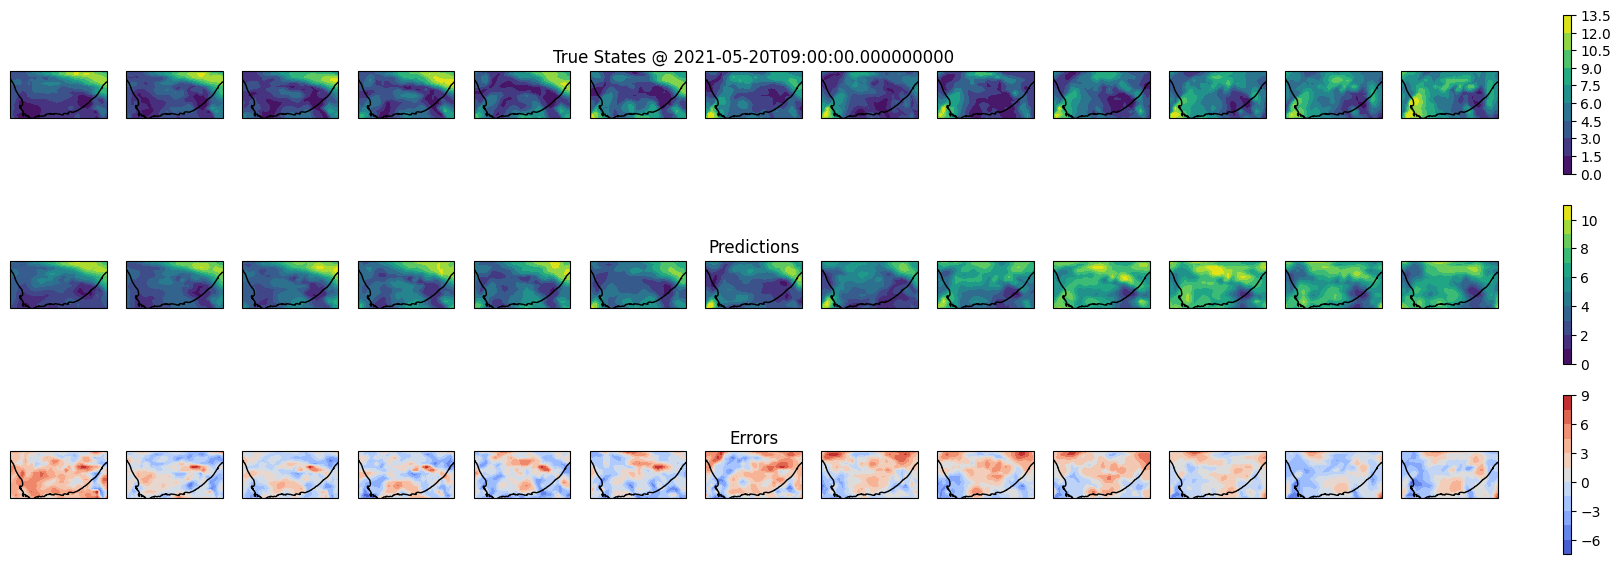

In [135]:
model_class.prediction_plots(seed=seed)